## Recurrent Neural Networks for Language Modeling 

Recurrent Neural Networks (RNNs) is a powerful family of neural networks that are widely used for sequence modeling tasks (e.g. stock price prediction, language modeling). RNNs ability to exploit temporal dependecies of entities in a sequence makes them powerful. In this exercise we will model a RNN and learn tips and tricks to improve the performance.

In this exercise, we will do the following.
1. Create word vectors for a dataset created from stories available [here](https://www.cs.cmu.edu/~spok/grimmtmp/)
2. Train a RNN model on the dataset and use it to output a new story

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from scipy.sparse import lil_matrix
#import nltk
#nltk.download() #tokenizers/punkt/PY3/english.pickle

c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Downloading Data

Downloading stories if not present in disk. There should be 100 files ('stories/001.txt','stories/002.txt', ...)

In [2]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'

# Create a directory if needed
dir_name = 'stories'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def maybe_download(filename):
  """Download a file if not present"""
  print('Downloading file: ', dir_name+ os.sep+filename)
    
  if not os.path.exists(dir_name+os.sep+filename):
    filename, _ = urlretrieve(url + filename, dir_name+os.sep+filename)
  else:
    print('File ',filename, ' already exists.')
  
  return filename

num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,101)]

for fn in filenames:
    maybe_download(fn)

File  001.txt  already exists.
File  002.txt  already exists.
File  003.txt  already exists.
File  004.txt  already exists.
File  005.txt  already exists.
File  006.txt  already exists.
File  007.txt  already exists.
File  008.txt  already exists.
File  009.txt  already exists.
File  010.txt  already exists.
File  011.txt  already exists.
File  012.txt  already exists.
File  013.txt  already exists.
File  014.txt  already exists.
File  015.txt  already exists.
File  016.txt  already exists.
File  017.txt  already exists.
File  018.txt  already exists.
File  019.txt  already exists.
File  020.txt  already exists.
File  021.txt  already exists.
File  022.txt  already exists.
File  023.txt  already exists.
File  024.txt  already exists.
File  025.txt  already exists.
File  026.txt  already exists.
File  027.txt  already exists.
File  028.txt  already exists.
File  029.txt  already exists.
File  030.txt  already exists.
File  031.txt  already exists.
File  032.txt  already exists.
File  03

## Reading data
Data will be stored in a list of lists where the each list represents a document and document is a list of words. We will then break the text into bigrams

In [3]:
def read_data(filename):
  
  with open(filename) as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = list(data)
  return data

documents = []
global documents
for i in range(num_files):    
    print('\nProcessing file %s'%os.path.join(dir_name,filenames[i]))
    chars = read_data(os.path.join(dir_name,filenames[i]))
    two_grams = [''.join(chars[ch_i:ch_i+2]) for ch_i in range(0,len(chars)-2,2)]
    documents.append(two_grams)
    print('Data size (Characters) (Document %d) %d' %(i,len(two_grams)))
    print('Sample string (Document %d) %s'%(i,two_grams[:50]))


Processing file stories\001.txt
Data size (Characters) (Document 0) 3667
Sample string (Document 0) ['in', ' o', 'ld', 'en', ' t', 'im', 'es', ' w', 'he', 'n ', 'wi', 'sh', 'in', 'g ', 'st', 'il', 'l ', 'he', 'lp', 'ed', ' o', 'ne', ', ', 'th', 'er', 'e ', 'li', 've', 'd ', 'a ', 'ki', 'ng', '\nw', 'ho', 'se', ' d', 'au', 'gh', 'te', 'rs', ' w', 'er', 'e ', 'al', 'l ', 'be', 'au', 'ti', 'fu', 'l,']

Processing file stories\002.txt
Data size (Characters) (Document 1) 4928
Sample string (Document 1) ['ha', 'rd', ' b', 'y ', 'a ', 'gr', 'ea', 't ', 'fo', 're', 'st', ' d', 'we', 'lt', ' a', ' w', 'oo', 'd-', 'cu', 'tt', 'er', ' w', 'it', 'h ', 'hi', 's ', 'wi', 'fe', ', ', 'wh', 'o ', 'ha', 'd ', 'an', '\no', 'nl', 'y ', 'ch', 'il', 'd,', ' a', ' l', 'it', 'tl', 'e ', 'gi', 'rl', ' t', 'hr', 'ee']

Processing file stories\003.txt
Data size (Characters) (Document 2) 9745
Sample string (Document 2) ['a ', 'ce', 'rt', 'ai', 'n ', 'fa', 'th', 'er', ' h', 'ad', ' t', 'wo', ' s', 'on', 's,', ' 

Data size (Characters) (Document 35) 8219
Sample string (Document 35) ['it', ' i', 's ', 'no', 'w ', 'lo', 'ng', ' a', 'go', ', ', 'qu', 'it', 'e ', 'tw', 'o ', 'th', 'ou', 'sa', 'nd', ' y', 'ea', 'rs', ', ', 'si', 'nc', 'e ', 'th', 'er', 'e ', 'wa', 's\n', 'a ', 'ri', 'ch', ' m', 'an', ' w', 'ho', ' h', 'ad', ' a', ' b', 'ea', 'ut', 'if', 'ul', ' a', 'nd', ' p', 'io']

Processing file stories\037.txt
Data size (Characters) (Document 36) 2151
Sample string (Document 36) ['a ', 'fa', 'rm', 'er', ' o', 'nc', 'e ', 'ha', 'd ', 'a ', 'fa', 'it', 'hf', 'ul', ' d', 'og', ' c', 'al', 'le', 'd ', 'su', 'lt', 'an', ', ', 'wh', 'o ', 'ha', 'd ', 'gr', 'ow', 'n\n', 'ol', 'd,', ' a', 'nd', ' l', 'os', 't ', 'al', 'l ', 'hi', 's ', 'te', 'et', 'h,', ' s', 'o ', 'th', 'at', ' h']

Processing file stories\038.txt
Data size (Characters) (Document 37) 5129
Sample string (Document 37) ['on', 'ce', ' u', 'po', 'n ', 'a ', 'ti', 'me', ', ', 'a ', 'ce', 'rt', 'ai', 'n ', 'ki', 'ng', ' w', 'as', ' h', 'un',

Data size (Characters) (Document 57) 4538
Sample string (Document 57) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' u', 'po', 'n ', 'a ', 'ti', 'me', ' a', ' q', 'ue', 'en', ' t', 'o ', 'wh', 'om', ' g', 'od', ' h', 'ad', ' g', 'iv', 'en', ' n', 'o ', 'ch', 'il', 'dr', 'en', '.\n', 'ev', 'er', 'y ', 'mo', 'rn', 'in', 'g ', 'sh', 'e ', 'we', 'nt', ' i', 'nt', 'o ', 'th']

Processing file stories\059.txt
Data size (Characters) (Document 58) 636
Sample string (Document 58) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' v', 'er', 'y ', 'ol', 'd ', 'ma', 'n,', ' w', 'ho', 'se', ' e', 'ye', 's ', 'ha', 'd ', 'be', 'co', 'me', ' d', 'im', ', ', 'hi', 's ', 'ea', 'rs', '\nd', 'ul', 'l ', 'of', ' h', 'ea', 'ri', 'ng', ', ', 'hi', 's ', 'kn', 'ee', 's ', 'tr', 'em', 'bl']

Processing file stories\060.txt
Data size (Characters) (Document 59) 786
Sample string (Document 59) ['a ', 'li', 'tt', 'le', ' b', 'ro', 'th', 'er', ' a', 'nd', ' s', 'is', 'te', 'r ', 'we', 're', ' o', 'nc', 'e ', 'pl', '

Data size (Characters) (Document 81) 10822
Sample string (Document 81) ['hi', 'll', ' a', 'nd', ' v', 'al', 'e ', 'do', ' n', 'ot', ' m', 'ee', 't,', ' b', 'ut', ' t', 'he', ' c', 'hi', 'ld', 're', 'n ', 'of', ' m', 'en', ' d', 'o,', ' g', 'oo', 'd ', 'an', 'd ', 'ba', 'd.', '\ni', 'n ', 'th', 'is', ' w', 'ay', ' a', ' s', 'ho', 'em', 'ak', 'er', ' a', 'nd', ' a', ' t']

Processing file stories\083.txt
Data size (Characters) (Document 82) 5480
Sample string (Document 82) ['\th', 'an', 's ', 'th', 'e ', 'he', 'dg', 'eh', 'og', '\n\n', 'th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' c', 'ou', 'nt', 'ry', ' m', 'an', ' w', 'ho', ' h', 'ad', ' m', 'on', 'ey', ' a', 'nd', ' l', 'an', 'd ', 'in', ' p', 'le', 'nt', 'y,', ' b', 'ut', '\nh', 'ow', 'ev', 'er', ' r', 'ic', 'h ']

Processing file stories\084.txt
Data size (Characters) (Document 83) 658
Sample string (Document 83) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' m', 'ot', 'he', 'r ', 'wh', 'o ', 'ha', 'd ', 'a ', 'li', 'tt', 'l

## Building the Dictionaries (Bigrams)
Builds the following. To understand each of these elements, let us also assume the text "I like to go to school"

* `dictionary`: maps a string word to an ID (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: maps an ID to a string word (e.g. {0:I, 1:like, 2:to, 3:go, 4:school}
* `count`: List of list of (word, frequency) elements (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)]
* `data` : Contain the string of text we read, where string words are replaced with word IDs (e.g. [0, 1, 2, 3, 2, 4])

It also introduces an additional special token `UNK` to denote rare words to are too rare to make use of.

In [4]:


def build_dataset(documents):
    chars = []
    # This is going to be a list of lists
    # Where the outer list denote each document
    # and the inner lists denote words in a given document
    data_list = []
  
    for d in documents:
        chars.extend(d)
    print('%d Characters found.'%len(chars))
    count = []
    # Get the bigram sorted by their frequency (Highest comes first)
    count.extend(collections.Counter(chars).most_common())
    
    # Create an ID for each bigram by giving the current length of the dictionary
    # And adding that item to the dictionary
    # Start with 'UNK' that is assigned to too rare words
    dictionary = dict({'UNK':0})
    for char, c in count:
        # Only add a bigram to dictionary if its frequency is more than 10
        if c > 10:
            dictionary[char] = len(dictionary)    
    
    unk_count = 0
    # Traverse through all the text we have
    # to replace each string word with the ID of the word
    for d in documents:
        data = list()
        for char in d:
            # If word is in the dictionary use the word ID,
            # else use the ID of the special token "UNK"
            if char in dictionary:
                index = dictionary[char]        
            else:
                index = dictionary['UNK']
                unk_count += 1
            data.append(index)
            
        data_list.append(data)
        
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data_list, count, dictionary, reverse_dictionary

global data_list, count, dictionary, reverse_dictionary,vocabulary_size

# Print some statistics about data
data_list, count, dictionary, reverse_dictionary = build_dataset(documents)
print('Most common words (+UNK)', count[:5])
print('Least common words (+UNK)', count[-15:])
print('Sample data', data_list[0][:10])
print('Sample data', data_list[1][:10])
print('Vocabulary: ',len(dictionary))
vocabulary_size = len(dictionary)
del documents  # To reduce memory.

449177 Characters found.
Most common words (+UNK) [('e ', 15229), ('he', 15164), (' t', 13443), ('th', 13076), ('d ', 10687)]
Least common words (+UNK) [("'p", 1), ('mc', 1), ('b-', 1), ('sd', 1), (' z', 1), ('dh', 1), ('pw', 1), ('".', 1), ('m?', 1), ('\t"', 1), ("x'", 1), ('bj', 1), ('gy', 1), ('hd', 1), ("a'", 1)]
Sample data [15, 28, 86, 23, 3, 95, 74, 11, 2, 16]
Sample data [22, 156, 25, 37, 82, 185, 43, 9, 90, 19]
Vocabulary:  544


## Generating Batches of Data
The following object generates a batch of data which will be used to train the RNN. More specifically the generator breaks a given sequence of words into `batch_size` segments. We also maintain a cursor for each segment. So whenever we create a batch of data, we sample one item from each segment and update the cursor of each segment. 

In [5]:
class DataGeneratorOHE(object):
    
    def __init__(self,text,batch_size,num_unroll):
        # Text where a bigram is denoted by its ID
        self._text = text
        # Number of bigrams in the text
        self._text_size = len(self._text)
        # Number of datapoints in a batch of data
        self._batch_size = batch_size
        # Num unroll is the number of steps we unroll the RNN in a single training step
        # This relates to the truncated backpropagation we discuss in Chapter 6 text
        self._num_unroll = num_unroll
        # We break the text in to several segments and the batch of data is sampled by
        # sampling a single item from a single segment
        self._segments = self._text_size//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
    def next_batch(self):
        '''
        Generates a single batch of data
        '''
        # Train inputs (one-hot-encoded) and train outputs (one-hot-encoded)
        batch_data = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        
        # Fill in the batch datapoint by datapoint
        for b in range(self._batch_size):
            # If the cursor of a given segment exceeds the segment length
            # we reset the cursor back to the beginning of that segment
            if self._cursor[b]+1>=self._text_size:
                self._cursor[b] = b * self._segments
            
            # Add the text at the cursor as the input
            batch_data[b,self._text[self._cursor[b]]] = 1.0
            # Add the preceding bigram as the label to be predicted
            batch_labels[b,self._text[self._cursor[b]+1]]= 1.0                       
            # Update the cursor
            self._cursor[b] = (self._cursor[b]+1)%self._text_size
                    
        return batch_data,batch_labels
        
    def unroll_batches(self):
        '''
        This produces a list of num_unroll batches
        as required by a single step of training of the RNN
        '''
        unroll_data,unroll_labels = [],[]
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()            
            unroll_data.append(data)
            unroll_labels.append(labels)
        
        return unroll_data, unroll_labels
    
    def reset_indices(self):
        '''
        Used to reset all the cursors if needed
        '''
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
# Running a tiny set to see if things are correct
dg = DataGeneratorOHE(data_list[0][25:50],5,5)
u_data, u_labels = dg.unroll_batches()

# Iterate through each data batch in the unrolled set of batches
for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = np.argmax(dat,axis=1)
    lbl_ind = np.argmax(lbl,axis=1)
    print('\tInputs:')
    for sing_dat in dat_ind:
        print('\t%s (%d)'%(reverse_dictionary[sing_dat],sing_dat),end=", ")
    print('\n\tOutput:')
    for sing_lbl in lbl_ind:        
        print('\t%s (%d)'%(reverse_dictionary[sing_lbl],sing_lbl),end=", ")



Unrolled index 0
	Inputs:
	e  (1), 	ki (131), 	 d (48), 	 w (11), 	be (70), 
	Output:
	li (98), 	ng (33), 	au (195), 	er (14), 	au (195), 

Unrolled index 1
	Inputs:
	li (98), 	ng (33), 	au (195), 	er (14), 	au (195), 
	Output:
	ve (41), 	
w (169), 	gh (106), 	e  (1), 	ti (112), 

Unrolled index 2
	Inputs:
	ve (41), 	
w (169), 	gh (106), 	e  (1), 	ti (112), 
	Output:
	d  (5), 	ho (62), 	te (61), 	al (84), 	fu (228), 

Unrolled index 3
	Inputs:
	d  (5), 	ho (62), 	te (61), 	al (84), 	fu (228), 
	Output:
	a  (82), 	se (58), 	rs (137), 	l  (56), 	l, (257), 

Unrolled index 4
	Inputs:
	a  (82), 	se (58), 	rs (137), 	l  (56), 	be (70), 
	Output:
	ki (131), 	 d (48), 	 w (11), 	be (70), 	au (195), 

## Recurrent Neural Network
Here we implement and train our recurrent model that will take an output a new story

## Defining Hyperparameters

Here we define several hyperparameters required.
* `num_unroll`: Number of steps we unroll over time during optimizing
* `batch_size`: Number of datapoints in a single batch
* `hidden`: Number of hidden neurons in the state

In [6]:
tf.reset_default_graph()

# Number of steps to unroll
num_unroll = 50 

batch_size = 64 # At train time
test_batch_size = 1 # At test time

# Number of hidden neurons in the state
hidden = 64

# Input size and output Size
in_size,out_size = vocabulary_size,vocabulary_size


## Defining Inputs and Outputs
Here we define training inputs (`train_dataset`) and outputs (`train_labels`), validation inputs (`valid_dataset`) and outputs (`valid_labels`) and test inputs (`test_dataset`).

In [7]:
# Train dataset
# We use unrolling over time
train_dataset, train_labels = [],[]
for ui in range(num_unroll):
    train_dataset.append(tf.placeholder(tf.float32, shape=[batch_size,in_size],name='train_dataset_%d'%ui))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,out_size],name='train_labels_%d'%ui))

# Validation dataset    
valid_dataset = tf.placeholder(tf.float32, shape=[1,in_size],name='valid_dataset')
valid_labels = tf.placeholder(tf.float32, shape=[1,out_size],name='valid_labels')

# Test dataset
test_dataset = tf.placeholder(tf.float32, shape=[test_batch_size,in_size],name='test_dataset')

## Defining Model Parameters and Other Variables
Here we define model parameters. First we define three different sets of weights (`W_xh`,`W_hh` and `W_hy`). We also define a variable to maintain the hidden state. There needs to be three separate variables for the hidden state to be used during training(`prev_train_h`), validation (`prev_valid_h`) and testing (`prev_test_h`).

In [8]:
# Weights between inputs and h
W_xh = tf.Variable(tf.truncated_normal([in_size,hidden],stddev=0.02,dtype=tf.float32),name='W_xh')

# Weights between h and h
W_hh = tf.Variable(tf.truncated_normal([hidden,hidden],stddev=0.02,dtype=tf.float32),name='W_hh')

# Weights between h and y
W_hy = tf.Variable(tf.truncated_normal([hidden,out_size],stddev=0.02,dtype=tf.float32),name='W_hy')

# Maintain the previous state of hidden nodes in an un-trainable variable (Training data)
prev_train_h = tf.Variable(tf.zeros([batch_size,hidden],dtype=tf.float32),name='train_h',trainable=False)

# Maintain the previous state of hidden nodes in an un-trainable variable (Validation data)
prev_valid_h = tf.Variable(tf.zeros([1,hidden],dtype=tf.float32),name='valid_h',trainable=False)

# Maintain the previous state of hidden nodes in testing phase
prev_test_h = tf.Variable(tf.zeros([test_batch_size,hidden],dtype=tf.float32),name='test_h')


## Defining Inference of the RNN
This is the most crucial bit of RNN and what makes it different from feed forward networks. Here we define operations related to:
* Calculating training/validation/test hidden outputs
* Calculating training/validation/test predictions

In [9]:
# ===============================================================================
# Train score (unnormalized) values and predictions (normalized)
y_scores, y_predictions = [],[]

# Appending the calculated output of RNN for each step in the num_unroll steps
outputs = list()

# This will be iteratively used within num_unroll steps of calculation
output_h = prev_train_h

# Calculating the output of the RNN for num_unroll steps
# (as required by the truncated BPTT)
for ui in range(num_unroll):   
        output_h = tf.nn.tanh(
            tf.matmul(tf.concat([train_dataset[ui],output_h],1),
                      tf.concat([W_xh,W_hh],0)) 
        )    
        outputs.append(output_h)

# Get the scores and predictions for all the RNN outputs we produced for num_unroll steps
y_scores = [tf.matmul(outputs[ui],W_hy) for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# We calculate train perplexity with the predictions made by the RNN
train_perplexity_without_exp = tf.reduce_sum(tf.concat(train_labels,0)*-tf.log(tf.concat(y_predictions,0)+1e-10))/(num_unroll*batch_size)

# ===============================================================================
# Validation data related inference logic 
# (very similar to the training inference logic)

# Compute the next valid state (only for 1 step)
next_valid_state = tf.nn.tanh(tf.matmul(valid_dataset,W_xh)  +
                                tf.matmul(prev_valid_h,W_hh))

# Calculate the prediction using the state output of the RNN
# But before that, assign the latest state output of the RNN
# to the state variable of the validation phase
# So you need to make sure you execute valid_predictions operation
# To update the validation state
with tf.control_dependencies([tf.assign(prev_valid_h,next_valid_state)]):
    valid_scores = tf.matmul(next_valid_state,W_hy) 
    valid_predictions = tf.nn.softmax(valid_scores)

# Validation data related perplexity
valid_perplexity_without_exp = tf.reduce_sum(valid_labels*-tf.log(valid_predictions+1e-10))

# ===============================================================================
# Test data realted inference logic

# Calculating hidden output for test data
next_test_state = tf.nn.tanh(tf.matmul(test_dataset,W_xh) +
                          tf.matmul(prev_test_h,W_hh)
                         )

# Making sure that the test hidden state is updated 
# every time we make a prediction
with tf.control_dependencies([tf.assign(prev_test_h,next_test_state)]):
    test_prediction = tf.nn.softmax(tf.matmul(next_test_state,W_hy))


## Calculating RNN Loss
We calculate the training and validation loss of RNN here. It's a typical cross entropy loss calculated over all the scores we obtained for training data (`rnn_loss`) and validation data (`rnn_valid_loss`).

In [10]:
# Here we make sure that before calculating the loss, the state variable is updated
# with the last RNN output state we obtained
with tf.control_dependencies([tf.assign(prev_train_h,output_h)]):
    # We calculate the softmax cross entropy for all the predictions we obtained
    # in all num_unroll steps at once.
    rnn_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=tf.concat(y_scores,0), labels=tf.concat(train_labels,0)
    ))
    
# Validation RNN loss    
rnn_valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
   logits=valid_scores, labels=valid_labels))

## Defining Learning Rate and the Optimizer with Gradient Clipping
Here we define the learning rate and the optimizer we're going to use. We will be using the Adam optimizer as it is one of the best optimizers out there. Furthermore we use gradient clipping to prevent any gradient explosions.

In [11]:
# Be very careful with the learning rate when using Adam
rnn_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Optimization with graident clipping
gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

## Resetting Operations for Resetting Hidden States
Sometimes the state variable needs to be reset (e.g. when starting predictions at a beginning of a new epoch)

In [12]:
# Reset the hidden states
reset_train_h_op = tf.assign(prev_train_h,tf.zeros([batch_size,hidden],dtype=tf.float32))
reset_valid_h_op = tf.assign(prev_valid_h,tf.zeros([1,hidden],dtype=tf.float32))

# Note that we are using small imputations when resetting the test state
# As this helps to add more variation to the generated text
reset_test_h_op = tf.assign(prev_test_h,tf.truncated_normal([test_batch_size,hidden],stddev=0.01,dtype=tf.float32))

## Prediction Sampling
We select the word corresponding to the highest index of the prediction vector. We will later see different sampling strategies.

In [13]:
def sample(distribution):
  '''
  Sample a word from the prediction distribution
  '''  
  best_idx = np.argmax(distribution)
  return best_idx

## Running the RNN to Generate Text

Here we train the RNN on the available data and generate text using the trained RNN for several steps. First we create a validation set by extracting text snippets (that are not present in training data) from longer documents. Then at each training step, we train the RNN on several randomly picked documents. From each document we extract text for `steps_per_document` steps. We also report the train and validation perplexities at the end of each step. Finally we test the RNN by asking it to generate some new text starting from a randomly picked bigram.

In [14]:
num_steps = 26 # Number of steps we run the algorithm for
# How many training steps are performed for each document in a single step
steps_per_document = 100 

# How often we run validation
valid_summary = 1

# In the book we run tests with this set to both 20 and 100
train_doc_count = 20
# Number of docs we use in a single step
# When train_doc_count = 20 => train_docs_to_use = 5
# # When train_doc_count = 100 => train_docs_to_use = 10
train_docs_to_use =5 

# Store the training and validation perplexity at each step
valid_perplexity_ot = []
train_perplexity_ot = []

session = tf.InteractiveSession()
# Initializing variables
tf.global_variables_initializer().run()

print('Initialized')
average_loss = 0

# We use the first 10 documents that has 
# more than (num_steps+1)*steps_per_document bigrams for creating the validation dataset

# Identify the first 10 documents following the above condition
long_doc_ids = []
for di in range(num_files):
  if len(data_list[di])>(num_steps+1)*steps_per_document:
    long_doc_ids.append(di)
  if len(long_doc_ids)==10:
    break

# Generating validation data
data_gens = []
valid_gens = []
for fi in range(num_files):
  # Get all the bigrams if the document id is not in the validation document ids
  if fi not in long_doc_ids:
    data_gens.append(DataGeneratorOHE(data_list[fi],batch_size,num_unroll))
  # if the document is in the validation doc ids, only get up to the 
  # last steps_per_document bigrams and use the last steps_per_document bigrams as validation data
  else:
    data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document],batch_size,num_unroll))
    # Defining the validation data generator
    valid_gens.append(DataGeneratorOHE(data_list[fi][-steps_per_document:],1,1))


feed_dict = {}
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:                    
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):
            
            # Get a set of unrolled batches
            u_data, u_labels = data_gens[di].unroll_batches()
            
            # Populate the feed dict by using each of the data batches
            # present in the unrolled data
            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
                feed_dict[train_dataset[ui]]=dat
                feed_dict[train_labels[ui]] = lbl            
            
            # Running the TensorFlow operation
            _, l, step_predictions, _, step_labels, step_perplexity = \
            session.run([rnn_optimizer, rnn_loss, y_predictions,
                         train_dataset,train_labels,train_perplexity_without_exp], 
                        feed_dict=feed_dict)
            
            # Update doc perplexity variable
            doc_perplexity += step_perplexity
            # Update average step perplexity 
            average_loss += step_perplexity
                
        print('Document %d Step %d processed (Perplexity: %.2f).'
              %(di,step+1,np.exp(doc_perplexity/steps_per_document))
             )
        
        # resetting hidden state after processing a single document
        # It's still questionable if this adds value in terms of learning
        # One one hand it's intuitive to reset the state when learning a new document
        # On the other hand this approach creates a bias for the state to be zero
        # We encourage the reader to investigate further the effect of resetting the state
        session.run(reset_train_h_op) 
    
    # Validation phase
    if step % valid_summary == 0:
      
      # Compute average loss
      average_loss = average_loss / (train_docs_to_use*steps_per_document*valid_summary)
      
      print('Average loss at step %d: %f' % (step+1, average_loss))
      print('\tPerplexity at step %d: %f' %(step+1, np.exp(average_loss)))
      train_perplexity_ot.append(np.exp(average_loss))
      
      average_loss = 0 # reset loss
      
      valid_loss = 0 # reset loss
      
      # calculate valid perplexity
      for v_doc_id in range(10):
          # Remember we process things as bigrams
          # So need to divide by 2
          for v_step in range(steps_per_document//2):
            uvalid_data,uvalid_labels = valid_gens[v_doc_id].unroll_batches()        

            # Run validation phase related TensorFlow operations       
            v_perp = session.run(
                valid_perplexity_without_exp,
                feed_dict = {valid_dataset:uvalid_data[0],valid_labels: uvalid_labels[0]}
            )

            valid_loss += v_perp
            
          session.run(reset_valid_h_op)
          # Reset validation data generator cursor
          valid_gens[v_doc_id].reset_indices()    
    
      print()
      v_perplexity = np.exp(valid_loss/(steps_per_document*10.0//2))
      print("Valid Perplexity: %.2f\n"%v_perplexity)
      valid_perplexity_ot.append(v_perplexity)
        
      # Generating new text ...
      # We will be generating one segment having 1000 bigrams
      # Feel free to generate several segments by changing
      # the value of segments_to_generate
      print('Generated Text after epoch %d ... '%step)  
      segments_to_generate = 1
      chars_in_segment = 1000
    
      for _ in range(segments_to_generate):
        print('======================== New text Segment ==========================')
        # Start with a random word
        test_word = np.zeros((1,in_size),dtype=np.float32)
        test_word[0,data_list[np.random.randint(0,num_files)][np.random.randint(0,100)]] = 1.0
        print("\t",reverse_dictionary[np.argmax(test_word[0])],end='')
        
        # Generating words within a segment by feeding in the previous prediction
        # as the current input in a recursive manner
        for _ in range(chars_in_segment):    
          test_pred = session.run(test_prediction, feed_dict = {test_dataset:test_word})  
          next_ind = sample(test_pred.ravel())
          test_word = np.zeros((1,in_size),dtype=np.float32)
          test_word[0,next_ind] = 1.0
          print(reverse_dictionary[next_ind],end='')
        
        print("")
        # Reset test state
        session.run(reset_test_h_op)
        print('====================================================================')
      print("")


Initialized


Document 18 Step 1 processed (Perplexity: 215.57).
Document 6 Step 1 processed (Perplexity: 162.49).
Document 1 Step 1 processed (Perplexity: 166.04).
Document 14 Step 1 processed (Perplexity: 126.05).
Document 9 Step 1 processed (Perplexity: 75.50).
Average loss at step 1: 4.947378
	Perplexity at step 1: 140.805218

Valid Perplexity: 83.21

Generated Text after epoch 0 ... 
======================== New text Segment ==========================
	 hat the was a e wre
of to the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was a e was of then the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

and and said UNKe yout full of have led the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth the youth 

and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the world he towere a broe.  oh will le, and when the had been the king's son had neck
and wept.  two of her tears went the wor

decon as they wase took for therew the king's son had go ey rapunzel into the fore, and thered the maiden, but she the tree, and the treat off the trorse, they came turnt, and the king's son was the king's son had go at show for the twelver when the king's son.  not knowever, for the went frown of it.  there when she was took thereng in the bip, toon she was to the fore, and thered the maiden, but she the tree, and the treat off the trorse, they came turnt, and the king's son was the king's son had go at show for the twelver when the king's son.  not knowever, for the went frown of it.  there when she was took thereng in the bip, toon she was to the fore, and thered the maiden, but she the tree, and the treat off the trorse, they came turnt, and the king's son was the king's son had go at show for the twelver when the king's son.  not knowever, for the went frown of it.  there when she was took thereng in the bip, toon she was to the fore, and thered the maiden, but she the tree, and t

twisting the thread, she answered, by twisting the thread.  on
this the king's son was alarmed and said, neither now nor ever
shall my beautiful bride touch a spinning-wheel.  and thus she
got rid of the hateful flax-spinning.  the your aunts, i amapperfore, she sat to the queen hat tooken, and thuse of the girl, and the the three, and that las and said, how do you come by
your falling lip.  by licking, she answered, by licking.  then
he asked the third, how do you come by your broad thumb.  by
twisting the thread, she answered, by twisting the thread.  on
this the king's son was alarmed and said, neither now nor ever
shall my beautiful bride touch a spinning-wheel.  and thus she
got rid of the hateful flax-spinning.  the your aunts, i amapperfore, she sat to the queen hat tooken, and thuse of the girl, and the the three, and that las and said, how do you come by
your falling lip.  by licking, she answered, by licking.  then
he asked the third, how do you come by your broad thumb.  by


     then the queen againto the door son way dears of the beast, whice she was to the deared himself.  he sprang as she did not roe, when his feach and the nurse, and the king to the king had suffear, and said,
     how fares my child, how fares my roe.
     then the queen againto the door son way dears of the beast, whice she was to the deared himself.  he sprang as she did not roe, when his feach and the nurse, and the king to the king had suffear, and said,
     how fares my child, how fares my roe.
     then the queen againto the door son way dears of the beast, whice she was to the deared himself.  he sprang as she did not roe, when his feach and the nurse, and the king to the king had suffear, and said,
     how fares my child, how fares my roe.
     then the queen againto the door son way dears of the beast, wh



Document 9 Step 17 processed (Perplexity: 7.53).
Document 4 Step 17 processed (Perplexity: 9.85).
Document 19 Step 17 processed (Perplexity: 5.69).
Document 14 Step 17

wedding-mantle.  then it will be your
wedding-mantle.  then it will be your
wedding-mantle.  then it will be your
wedding-mantle.  then it will be your
wedding-mantle.  then it will be your
wedding-mantle.  



Document 1 Step 20 processed (Perplexity: 5.68).
Document 16 Step 20 processed (Perplexity: 2.37).
Document 13 Step 20 processed (Perplexity: 11.09).
Document 5 Step 20 processed (Perplexity: 13.41).
Document 15 Step 20 processed (Perplexity: 8.69).
Average loss at step 20: 1.952932
	Perplexity at step 20: 7.049326

Valid Perplexity: 46.23

Generated Text after epoch 19 ... 
======================== New text Segment ==========================
	 d becaughter.  the king's son was and not down to put he wore on, and the true bride to be cried -
     turn to be down, and there she was to be came for a biddent to the peach, and the king's son had however, and the king's son had down into the good out too his one was and go her and peep, and the pigeons pecked out the other eye from e

	 m whice rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, rapunzel, 

dearest wife.  thus he roamed about in misery for your happree, and it seemed so familiar to him that he went towards
it, and when he approached, rapunzel knew him and fell on his neck
and wept.  two of her tears wentingle into the loss of his
dearest wife.  thus he roamed about in misery for your happree, and it seemed so familiar to him that he went towards
it, and when he approached, rapunzel knew him and fell on his neck
and wept.  two of her tears wentingle into the loss of his
dearest wife.  thus he roamed about in misery for your happree, and it seemed so familiar to him that he went towards
it, and when he approached, rapunzel knew him and fell on his neck
and wept.  two of her tears wentingle into the loss of his
dearest wife.  thus he roamed about in misery for your happree, and it seemed so familiar to him that he went towards
it, and when he approached, rapunzel knew him and fell on his neck
and wept.  two of her tears wentingle into the loss of his
dearest wife.  thus he r

## Plotting Perplexity of RNN

After training the RNN, we plot the train and valid perplexity side by side

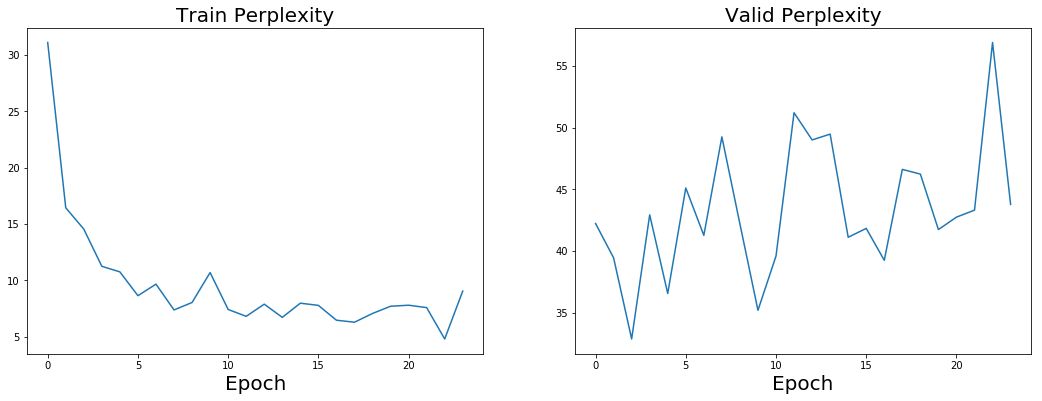

In [15]:
x_axis = np.arange(len(train_perplexity_ot[1:25]))
f,(ax1,ax2)=pylab.subplots(1,2,figsize=(18,6))

ax1.plot(x_axis,train_perplexity_ot[1:25],label='Train')
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='Valid')

pylab.title('Train and Valid Perplexity over Time',fontsize=24)
ax1.set_title('Train Perplexity',fontsize=20)
ax2.set_title('Valid Perplexity',fontsize=20)
ax1.set_xlabel('Epoch',fontsize=20)
ax2.set_xlabel('Epoch',fontsize=20)
pylab.savefig('RNN_perplexity.png')
pylab.show()

## RNN-CF - RNN with Contextual Features

Here we implement an extension of RNN which is described in this [paper](https://arxiv.org/pdf/1412.7753.pdf). RNN-CF differs from a standard RNN as the RNN-CF has two different states and one state is specifically designed to retain long term memory.

## Defining Hyperparameters

Here we define several hyperparameters required.
* `num_unroll`: Number of steps we unroll over time during optimizing
* `batch_size`: Number of datapoints in a single batch
* `hidden`: Number of hidden neurons in the state
* `hidden_context`: Number of hidden neurons in the context vector
* `alpha` : RNN-CF specific hyperparameter

In [16]:
tf.reset_default_graph()

# Number of steps to unroll
num_unroll = 50

batch_size = 64 # At train time
test_batch_size = 1 # At test time

# Number of hidden neurons in each state
hidden = 64
hidden_context = 64

alpha = 0.9

# Input size and output Size
in_size,out_size = vocabulary_size,vocabulary_size

## Defining Inputs and Outputs
Here we define training inputs (`train_dataset`) and outputs (`train_labels`), validation inputs (`valid_dataset`) and outputs (`valid_labels`) and test inputs (`test_dataset`).

In [17]:
# Train dataset
# We use unrolling over time
train_dataset, train_labels = [],[]
for ui in range(num_unroll):
    train_dataset.append(tf.placeholder(tf.float32, shape=[batch_size,in_size],name='train_dataset_%d'%ui))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,out_size],name='train_labels_%d'%ui))

# Validation dataset 
valid_dataset = tf.placeholder(tf.float32, shape=[1,in_size],name='valid_dataset')
valid_labels = tf.placeholder(tf.float32, shape=[1,out_size],name='valid_labels')

# Test dataset
test_dataset = tf.placeholder(tf.float32, shape=[test_batch_size,in_size],name='save_test_dataset')


## Defining Model Parameters and Other Variables
Here we define model parameters. First we define `A`,`B`,`R`,`P`,`U` and `V`. We also define a variable to maintain the hidden state. Each phase of training/validation/testing will have two state variables. For example for training we have `prev_train_h` and `prev_train_s`.

In [18]:
# Weights between inputs and h
A = tf.Variable(tf.truncated_normal([in_size,hidden],stddev=0.02,dtype=tf.float32),name='W_xh')
B = tf.Variable(tf.truncated_normal([in_size,hidden_context],stddev=0.02,dtype=tf.float32),name='W_xs')

# Weights between h and h
R = tf.Variable(tf.truncated_normal([hidden,hidden],stddev=0.02,dtype=tf.float32),name='W_hh')
P = tf.Variable(tf.truncated_normal([hidden_context,hidden],stddev=0.02,dtype=tf.float32),name='W_ss')

# Weights between h and y
U = tf.Variable(tf.truncated_normal([hidden,out_size],stddev=0.02,dtype=tf.float32),name='W_hy')
V = tf.Variable(tf.truncated_normal([hidden_context, out_size],stddev=0.02,dtype=tf.float32),name='W_sy')

# State variables for training data
prev_train_h = tf.Variable(tf.zeros([batch_size,hidden],dtype=tf.float32),name='train_h',trainable=False)
prev_train_s = tf.Variable(tf.zeros([batch_size,hidden_context],dtype=tf.float32),name='train_s',trainable=False)

# State variables for validation data
prev_valid_h = tf.Variable(tf.zeros([1,hidden],dtype=tf.float32),name='valid_h',trainable=False)
prev_valid_s = tf.Variable(tf.zeros([1,hidden_context],dtype=tf.float32),name='valid_s',trainable=False)

# State variables for test data
prev_test_h = tf.Variable(tf.zeros([test_batch_size,hidden],dtype=tf.float32),name='test_h')
prev_test_s = tf.Variable(tf.zeros([test_batch_size,hidden_context],dtype=tf.float32),name='test_s')


## Defining Inference of the RNN
This is the most crucial bit of RNN and what makes it different from feed forward networks. Here we define operations related to:
* Calculating training/validation/test hidden outputs (h and s)
* Calculating training/validation/test predictions

In [19]:
# ===============================================================================
# Train score (unnormalized) values and predictions (normalized)
y_scores, y_predictions = [],[]

# These will be iteratively used within num_unroll steps of calculation
next_h_state = prev_train_h
next_s_state = prev_train_s

# Appending the calculated state outputs of RNN for each step in the num_unroll steps
next_h_states_unrolled, next_s_states_unrolled = [],[]

# Calculating the output of the RNN for num_unroll steps
# (as required by the truncated BPTT)
for ui in range(num_unroll):      
    next_h_state = tf.nn.tanh(
        tf.matmul(tf.concat([train_dataset[ui],prev_train_h,prev_train_s],1),
                  tf.concat([A,R,P],0))
    )    
    next_s_state = (1-alpha)*tf.matmul(train_dataset[ui],B) + alpha * next_s_state
    next_h_states_unrolled.append(next_h_state)
    next_s_states_unrolled.append(next_s_state)

# Get the scores and predictions for all the RNN outputs we produced for num_unroll steps
y_scores = [tf.matmul(next_h_states_unrolled[ui],U) + 
            tf.matmul(next_s_states_unrolled[ui],V) 
             for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# We calculate train perplexity with the predictions made by the RNN
train_perplexity_without_exp = tf.reduce_sum(tf.concat(train_labels,0)*-tf.log(tf.concat(y_predictions,0)+1e-10))/(num_unroll*batch_size)

# ===============================================================================
# Validation data related inference logic 
# (very similar to the training inference logic)

# Compute the next valid state (only for 1 step)
next_valid_s_state = (1-alpha) * tf.matmul(valid_dataset,B) + alpha * prev_valid_s
next_valid_h_state = tf.nn.tanh(tf.matmul(valid_dataset,A)  + 
                                tf.matmul(prev_valid_s, P) +
                                tf.matmul(prev_valid_h,R))


# Calculate the prediction using the state output of the RNN
# But before that, assign the latest state output of the RNN
# to the state variable of the validation phase
# So you need to make sure you execute rnn_valid_loss operation
# To update the validation state
with tf.control_dependencies([tf.assign(prev_valid_s, next_valid_s_state),
                              tf.assign(prev_valid_h,next_valid_h_state)]):        
    valid_scores = tf.matmul(prev_valid_h, U) + tf.matmul(prev_valid_s, V) 
    valid_predictions = tf.nn.softmax(valid_scores)
        
# Validation data related perplexity
valid_perplexity_without_exp = tf.reduce_sum(valid_labels*-tf.log(valid_predictions+1e-10))

# ===============================================================================
# Test data realted inference logic

# Calculating hidden output for test data
next_test_s = (1-alpha)*tf.matmul(test_dataset,B)+ alpha*prev_test_s
                         
next_test_h = tf.nn.tanh(
    tf.matmul(test_dataset,A) + tf.matmul(prev_test_s,P) + 
    tf.matmul(prev_test_h, R)
                         )

# Making sure that the test hidden state is updated 
# every time we make a prediction
with tf.control_dependencies([tf.assign(prev_test_s,next_test_s),
                              tf.assign(prev_test_h,next_test_h)]):
    test_prediction = tf.nn.softmax(
        tf.matmul(prev_test_h,U) + tf.matmul(prev_test_s,V)
    ) 

## Calculating RNN Loss
We calculate the training and validation loss of RNN here. It's a typical cross entropy loss calculated over all the scores we obtained for training data (`rnn_loss`) and validation data (`rnn_valid_loss`).

In [20]:
# Here we make sure that before calculating the loss, the state variables are updated
# with the last RNN output state we obtained
with tf.control_dependencies([tf.assign(prev_train_s, next_s_state),
                              tf.assign(prev_train_h,next_h_state)]):
    rnn_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=tf.concat(y_scores,0), labels=tf.concat(train_labels,0)
    ))
        
rnn_valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
           logits=valid_scores, labels=valid_labels))

## Defining Learning Rate and the Optimizer with Gradient Clipping
Here we define the learning rate and the optimizer we're going to use. We will be using the Adam optimizer as it is one of the best optimizers out there. Furthermore we use gradient clipping to prevent any gradient explosions.

In [21]:
rnn_optimizer = tf.train.AdamOptimizer(learning_rate=.001)

gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

## Resetting Operations for Resetting Hidden States
Sometimes the state variable needs to be reset (e.g. when starting predictions at a beginning of a new epoch)

In [22]:
reset_prev_train_h_op = tf.assign(prev_train_h,tf.zeros([batch_size,hidden],dtype=tf.float32))
reset_prev_train_s_op = tf.assign(prev_train_s,tf.zeros([batch_size,hidden_context],dtype=tf.float32))

reset_valid_h_op = tf.assign(prev_valid_h,tf.zeros([1,hidden],dtype=tf.float32))
reset_valid_s_op = tf.assign(prev_valid_s,tf.zeros([1,hidden_context],dtype=tf.float32))

# Impute the testing states with noise
reset_test_h_op = tf.assign(prev_test_h,tf.truncated_normal([test_batch_size,hidden],stddev=0.01,dtype=tf.float32))
reset_test_s_op = tf.assign(prev_test_s,tf.truncated_normal([test_batch_size,hidden_context],stddev=0.01,dtype=tf.float32))

## Running the RNN-CF to Generate Text

Here we train the RNN on the available data and generate text using the trained RNN for several steps. First we create a validation set by extracting text snippets (that are not present in training data) from longer documents. Then at each training step, we train the RNN on several randomly picked documents. From each document we extract text for `steps_per_document` steps. We also report the train and validation perplexities at the end of each step. Finally we test the RNN by asking it to generate some new text starting from a randomly picked bigram.

In [23]:
num_steps = 26 # Number of steps we run the algorithm for
# How many training steps are performed for each document in a single step
steps_per_document = 100 

# How often we run validation
valid_summary = 1

# In the book we run tests with this set to both 20 and 100
train_doc_count = 100
train_docs_to_use = 10 # Number of docs we use in a single step

# Store the training and validation perplexity at each step
cf_valid_perplexity_ot = []
cf_train_perplexity_ot = []

session = tf.InteractiveSession()
# Initializing variables
tf.global_variables_initializer().run()

print('Initialized')
average_loss = 0

# We use the first 10 documents that has 
# more than (num_steps+1)*steps_per_document bigrams for creating the validation dataset

# Identify the first 10 documents following the above condition
long_doc_ids = []
for di in range(num_files):
  if len(data_list[di])>(num_steps+1)*steps_per_document:
    long_doc_ids.append(di)
  if len(long_doc_ids)==10:
    break

# Generating validation data
data_gens = []
valid_gens = []
for fi in range(num_files):
  # Get all the bigrams if the document id is not in the validation document ids
  if fi not in long_doc_ids:
    data_gens.append(DataGeneratorOHE(data_list[fi],batch_size,num_unroll))
  # if the document is in the validation doc ids, only get up to the 
  # last steps_per_document bigrams and use the last steps_per_document bigrams as validation data
  else:
    data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document],batch_size,num_unroll))
    # Defining the validation data generator
    valid_gens.append(DataGeneratorOHE(data_list[fi][-steps_per_document:],1,1))

feed_dict={}
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:                    
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):
            
            # Get a set of unrolled batches
            u_data, u_labels = data_gens[di].unroll_batches()
            
            # Populate the feed dict by using each of the data batches
            # present in the unrolled data
            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
                feed_dict[train_dataset[ui]]=dat
                feed_dict[train_labels[ui]] = lbl
            
            # Running the TensorFlow operations
            _, l, _, _, _, perp = session.run(
                [rnn_optimizer, rnn_loss, y_predictions,train_dataset,
                 train_labels, train_perplexity_without_exp], 
                feed_dict=feed_dict)
            
            # Update doc_perpelxity variable
            doc_perplexity += perp
            
            # Update the average_loss variable
            average_loss += perp
            
        print('Document %d Step %d processed (Perplexity: %.2f).'
              %(di,step+1,np.exp(doc_perplexity/(steps_per_document)))
             )

        # resetting hidden state after processing a single document
        # It's still questionable if this adds value in terms of learning
        # One one hand it's intuitive to reset the state when learning a new document
        # On the other hand this approach creates a bias for the state to be zero
        # We encourage the reader to investigate further the effect of resetting the state
        session.run([reset_prev_train_h_op, reset_prev_train_s_op]) # resetting hidden state for each document
    
    # Validation phase
    if step % valid_summary == 0:
      
      # Compute the average validation perplexity
      average_loss = average_loss / (train_docs_to_use*steps_per_document*valid_summary)
      
      # Print losses
      print('Average loss at step %d: %f' % (step+1, average_loss))
      print('\tPerplexity at step %d: %f' %(step+1, np.exp(average_loss)))
    
      cf_train_perplexity_ot.append(np.exp(average_loss))
      average_loss = 0 # reset loss
      valid_loss = 0 # reset loss
      
      # calculate valid perplexity
      for v_doc_id in range(10):
          # Remember we process things as bigrams
          # So need to divide by 2
          for v_step in range(steps_per_document//2):
            uvalid_data,uvalid_labels = valid_gens[v_doc_id].unroll_batches()        

            # Run validation phase related TensorFlow operations       
            v_perp = session.run(
                valid_perplexity_without_exp,
                feed_dict = {valid_dataset:uvalid_data[0],valid_labels: uvalid_labels[0]}
            )

            valid_loss += v_perp
            
          session.run([reset_valid_h_op, reset_valid_s_op])
          # Reset validation data generator cursor
          valid_gens[v_doc_id].reset_indices()    
    
      print()
      v_perplexity = np.exp(valid_loss/(steps_per_document*10.0//2))
      print("Valid Perplexity: %.2f\n"%v_perplexity)
      cf_valid_perplexity_ot.append(v_perplexity)
      
        
      # Generating new text ...
      # We will be generating one segment having 1000 bigrams
      # Feel free to generate several segments by changing
      # the value of segments_to_generate
      print('Generated Text after epoch %d ... '%step)  
      segments_to_generate = 1
      chars_in_segment = 1000
    
      for _ in range(segments_to_generate):
        print('======================== New text Segment ==========================')
        # Start with a random word
        test_word = np.zeros((1,in_size),dtype=np.float32)
        test_word[0,data_list[np.random.randint(0,num_files)][np.random.randint(0,100)]] = 1.0
        print("\t",reverse_dictionary[np.argmax(test_word[0])],end='')
        
        # Generating words within a segment by feeding in the previous prediction
        # as the current input in a recursive manner
        for _ in range(chars_in_segment):    
          test_pred = session.run(test_prediction, feed_dict = {test_dataset:test_word})  
          next_ind = sample(test_pred.ravel())
          test_word = np.zeros((1,in_size),dtype=np.float32)
          test_word[0,next_ind] = 1.0
          print(reverse_dictionary[next_ind],end='')
        
        print("")
        # Reset test state
        session.run([reset_test_h_op, reset_test_s_op])
      print("")

c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized


Document 11 Step 1 processed (Perplexity: 235.24).
Document 1 Step 1 processed (Perplexity: 166.14).
Document 8 Step 1 processed (Perplexity: 141.38).
Document 5 Step 1 processed (Perplexity: 90.15).
Document 52 Step 1 processed (Perplexity: 42.38).
Document 56 Step 1 processed (Perplexity: 24.69).
Document 43 Step 1 processed (Perplexity: 33.47).
Document 49 Step 1 processed (Perplexity: 30.25).
Document 0 Step 1 processed (Perplexity: 29.55).
Document 63 Step 1 processed (Perplexity: 28.88).
Average loss at step 1: 4.064881
	Perplexity at step 1: 58.257949

Valid Perplexity: 40.58

Generated Text after epoch 0 ... 
======================== New text Segment ==========================
	 they was then the forest then the forest then the forest therest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and the forestrest, and 

Document 55 Step 4 processed (Perplexity: 19.99).
Document 46 Step 4 processed (Perplexity: 25.28).
Document 33 Step 4 processed (Perplexity: 18.24).
Document 67 Step 4 processed (Perplexity: 15.41).
Document 47 Step 4 processed (Perplexity: 12.31).
Document 5 Step 4 processed (Perplexity: 16.18).
Document 53 Step 4 processed (Perplexity: 10.45).
Document 70 Step 4 processed (Perplexity: 16.56).
Average loss at step 4: 2.737173
	Perplexity at step 4: 15.443262

Valid Perplexity: 36.79

Generated Text after epoch 3 ... 
======================== New text Segment ==========================
	  for, my dear back with him to he to him, and her the king, and said, when she said that, and her that he peasand said, and her that, and said, i ame tooke took the oxen the king, and said, whent was and her the king, and said, and the king, said, i ame call, and said,
when the she said that, and the king, and said, when she said that, and her that he peasand said, and her that, and said, i ame tooke 

Document 14 Step 7 processed (Perplexity: 21.01).
Document 58 Step 7 processed (Perplexity: 3.34).
Document 25 Step 7 processed (Perplexity: 15.56).
Document 67 Step 7 processed (Perplexity: 12.56).
Document 85 Step 7 processed (Perplexity: 13.05).
Document 79 Step 7 processed (Perplexity: 9.12).
Average loss at step 7: 2.559466
	Perplexity at step 7: 12.928913

Valid Perplexity: 43.55

Generated Text after epoch 6 ... 
======================== New text Segment ==========================
	  every
lays, come of the paddock child some back
wout ith its out, whereupon the child she come ould saw have you.                                                                         iUNK
the paddock cries, huhuhu, huhu, huhu, huhu, huhuhu, hu, huhuhu, huhu, huhu, huhu, huhu, huhuhu, and smays out, whichild the paddock comes out, whereupon the child secone little
sister, have you not seen little red-stockings.  the paddock says,
no, i have not.  have you.                                          

Document 61 Step 10 processed (Perplexity: 13.38).
Document 68 Step 10 processed (Perplexity: 16.38).
Document 44 Step 10 processed (Perplexity: 10.35).
Document 69 Step 10 processed (Perplexity: 15.46).
Average loss at step 10: 2.599917
	Perplexity at step 10: 13.462614

Valid Perplexity: 30.46

Generated Text after epoch 9 ... 
======================== New text Segment ==========================
	  know so they saw a glastle maide, and wholeept the man he came to the could not rinto them.  they said, nowere to the came to the king's
daughter.  then hen he came to the could not rinto them.  they said, nowere to the came to the king's
daughter.  then hen he came to ther, they saw they said, nowere to the came to the gobless, but when saw they he could not ring to they they were to then himself they said, and the came to the good to they that the gobless, but when strout it was see he had not hey maiden he took him, but the he said, it the haver you
serve, and the mand said they they wi

Document 49 Step 13 processed (Perplexity: 9.30).
Document 82 Step 13 processed (Perplexity: 11.76).
Average loss at step 13: 2.302307
	Perplexity at step 13: 9.997217

Valid Perplexity: 30.75

Generated Text after epoch 12 ... 
======================== New text Segment ==========================
	 hedgehog, and the kingdom the king's
daughter saw that he had had been hand to himself known, and the hans the was shog told her, and the had father the was shog livery to him to give for him to
himself kingdom, and the he was came to the were told for her.  then the kingdom the kingdom the king's
daughter was to when told hand the have himself known, and the hans the was could shog told her he have himself known, and the had father the were kingdom the king's
daughter was to when told hand the have himself known, and the hans the was could shog told her he have himself known, and the had father the were kingdom the king's
daughter was to when told hand the have himself known, and the hans t


Valid Perplexity: 30.65

Generated Text after epoch 15 ... 
======================== New text Segment ==========================
	 e scullion to beautiful of the girl, and she she saw that she was a duck, and said,
what does my deserver, in a persone and the scullittlend to beautiful of the great the girl, and to the king, the scullion the sword and said, it the scullion the swould nothir giving befor and the scullion to beautiful of the girl, and the she swould the scullion to beautiful of the great she good, and she swould that gold woman the sculd beautiful of the gold that streaut of ble and the scullion to beautiful of the great the girl, and she swould the scullion to beautiful of the great she good, and she swould that gold woman the sculd beautiful of the gold that streaut of ble and the scullion to beautiful of the great the girl, and she swould the scullion to beautiful of the great she good, and she swould that gold woman the sculd beautiful of the gold that streaut of ble 

looked up andere friend when aw the wolf, was ashamed of having a made friend mady the friends bit the boarful no one the dog andere and not the boar, and not the wolf
so time to the tree.  they weree withought the wild boar, the with his will however, and not the caree wolf
so time, who the wolf's he midgehog and said the down it and at the dog andere and not the tree
looked up andere friend when aw the wolf, was ashamed of having a made friend mady the friends bit the boarful no one the dog andere and not the boar, and not the wolf
so time to the tree.  they weree withought the wild boar, the with his will however, and not the caree wolf
so time, who the wolf's he midgehog and said the down it and at the dog andere and not the tree
looked up andere friend when aw the wolf, was ashamed of having a made friend mady the friends bit the boarful no one the dog andere and not the boar, and not the wolf
so time to the tree.  they weree withought the wild boar, the with his will however, and

peasand begged their presented to him to him, and said, my dear
lord and he was that, and her eyes and said to her, and if it was not that, and her ey wasand begged the persent the presented ther the sant to before the king's daughterful precious and hervants, and when she tooked him and said, and the king's daughterful precious and his wife precious and said med to his forced to him it that, and her eyes, and said, i am yours, and if you said me - to my dear
long and dranking.  the king the said to him it that, and the king the dook a little.  shen she said, and that was she she was said, you wif you will gle
mine, i have yourselve yours, and me - to my dear
long and draught to the king, and said, my dear
lord and he was that wasand begged the king he present ther the king, and said, my dear
lord and him in the precious shad me - he had have brought baced here and her back with him took the presents, and when she took the presented and the king's daughterful precious and hervants, and

whouse, and when they had rode beautiful and the father, and said, i must you will my great your brother brother brother brother brother brother brotherse, anded home took his hisses, and
whouse, and when they had rode beautiful and the father, and said, i must you will my great your brother brother brother brother brother brother brotherse, anded home took his hisses, and
whouse, and when they had rode beautiful and the father, and said, i must you will my great your brother brother brother brother brother brother brotherse, anded home took his hisses, and
whouse, and when they had rode beautiful and the father, and said, i must you will my great your brother brother brother brother brother brother brotherse, anded home took his hisses, and
whouse, and when they had rode beautiful and the father, and said, i must you will my great your brother brother brother brother brother brother brotherse, anded home took his hisses, and
whouse, and when they had rode beautiful and the father, and

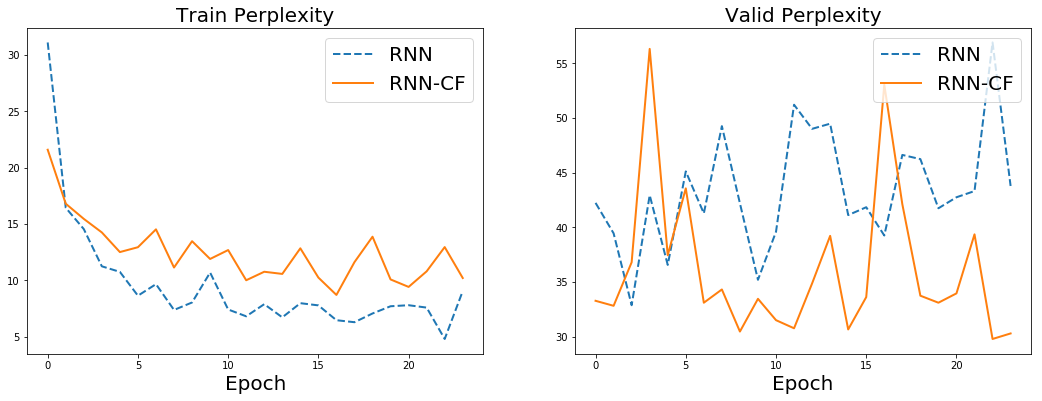

In [24]:

x_axis = np.arange(len(train_perplexity_ot[1:25]))
f,(ax1,ax2)=pylab.subplots(1,2,figsize=(18,6))

ax1.plot(x_axis,train_perplexity_ot[1:25],label='RNN',linewidth=2,linestyle='--')
ax1.plot(x_axis,cf_train_perplexity_ot[1:25],label='RNN-CF',linewidth=2)
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='RNN',linewidth=2,linestyle='--')
ax2.plot(x_axis, cf_valid_perplexity_ot[1:25], label='RNN-CF',linewidth=2)
ax1.legend(loc=1, fontsize=20)
ax2.legend(loc=1, fontsize=20)
pylab.title('Train and Valid Perplexity over Time (RNN vs RNN-CF)',fontsize=24)
ax1.set_title('Train Perplexity',fontsize=20)
ax2.set_title('Valid Perplexity',fontsize=20)
ax1.set_xlabel('Epoch',fontsize=20)
ax2.set_xlabel('Epoch',fontsize=20)
pylab.savefig('RNN_perplexity_cf.png')
pylab.show()